In [4]:
import numpy as np
import matplotlib.pyplot as plt
import sys
# import pyximport
# pyximport.install()
sys.path.append('../')
from QRT.RegressionTreeQuantile import RegressionTreeQuantile
from CRPStreeC.entropies_CRPS import entropies_CRPS
from CRPStreeC.RegressionTree import RegressionTree
from CRPStreeC.get_entropy import get_entropy
import pandas as pd
import random

import scipy 

In [ ]:
import CRPS.CRPS as pscore
import properscoring as ps

def get_entropy(vals):
    values = np.sort(vals)
    h = 0
    n = len(values)
    for i in range(1,n+1):
        h += i*(i-1)*(values[i-1]-values[n-i])
    return h/(n)**3

In [5]:
import itertools
def compute_expression(y):
    n = len(y)
    if n < 3:
        return 0
    
    y_sorted = sorted(y)
    
    sum_1 = 0
    sum_2 = 0
    
    # First sum: i < j < k
    for i, j, k in itertools.combinations(range(n), 3):
        sum_1 += (y_sorted[j] - y_sorted[i])
    
    # Second sum: j < k < i
    for j, k, i in itertools.combinations(range(n), 3):
        sum_2 += (y_sorted[i] - y_sorted[k])
    
    result = (2 / n**3) * (sum_1 + sum_2)
    
    return result*(n/(n-2))

In [8]:
if True:
    y = np.array(list(np.random.normal(0,3, 50)) + list(np.random.normal(1,3, 50)))

    import random
    random.shuffle(y)
else:
    y = np.array([5,3,7,6,2,4,8,1])

true_crps  = [0]
true_crps2 = [0]
true_crps3 = [0]
true_crps4 = [0]
for i in range(1,len(y)+1):
    true_crps.append(0)
    true_crps3.append(0)
    for j in range(i):
        crps,fcrps,acrps = pscore(y[:i],y[j]).compute()
        true_crps[-1] += crps /(i)
        true_crps3[-1] += ps.crps_ensemble(y[j], y[:i])/(i) 
    true_crps2.append(get_entropy(y[:i]))
    true_crps4.append(compute_expression(y[:i]))

In [9]:
n = len(y)
CRPS = 0
ysort = np.sort(y)
for ob in y:
    cdf_fc = np.linspace(1/n,1,n)
    cdf_ob = (ysort >= ob)
    all_mem = ysort
    delta_fc = np.array([all_mem[n+1] - all_mem[n] for n in range(len(all_mem)-1)] + list(np.zeros(1)), dtype=object) 
    crps = np.sum(np.array((cdf_fc - cdf_ob) ** 2)*delta_fc)
    CRPS += crps / len(y)
print(CRPS, true_crps[-1], true_crps4[-1])

1.7318213580215054 1.7318213580215054 1.731821358021448


In [10]:
order = np.array([i for i in range(len(y))]).astype(int)
entropies = entropies_CRPS(order, y, use_LOO=False)

# Checking the algorithm computes properly the CRPS

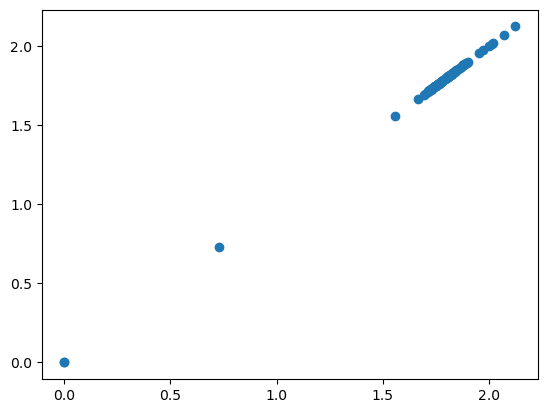

In [11]:
plt.scatter(entropies, true_crps)

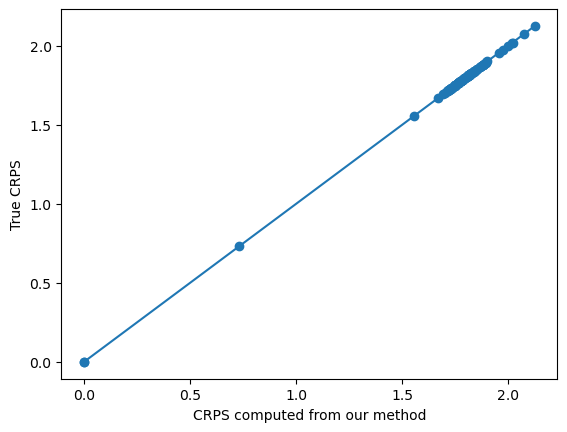

In [15]:
a = true_crps2
b = true_crps
plt.scatter(a, b)
plt.xlabel('CRPS computed from our method')
plt.ylabel('True CRPS')
m = min([np.min(a), np.min(b)])
M = max([np.max(a), np.max(b)])
plt.plot([m,M],[m,M])

# Time complexity of our method

In [13]:
time_bruteforce = []
time_us = []
ls_n = [25*i for i in range(1,26)]
for n in ls_n:
    y = np.random.normal(0, 1, n)
    #y = np.array(list(np.random.normal(0,3, 50)) + list(np.random.normal(1,3, 50)))
    import random
    from time import time
    random.shuffle(y)

    true_crps  = [0]
    true_crps3 = [0]

    t0 = time()
    for i in range(1,len(y)+1):
        true_crps.append(0)
        true_crps3.append(0)
        for j in range(i):
            crps,fcrps,acrps = pscore(y[:i],y[j]).compute()
            #true_crps3[-1] += ps.crps_ensemble(y[j], y[:i])/(i)
    t1 = time()
    time_bruteforce.append(t1-t0)
    order = np.array([i for i in range(len(y))]).astype(int)
    t0 = time()
    entropies = entropies_CRPS(order, y)
    t1 = time()
    time_us.append(t1-t0)

In [10]:
time_us = np.zeros(len(ls_n))
for i_n, n in enumerate(ls_n):
    for ite in range(20):
        y = np.random.normal(0, 1, n)
        #y = np.array(list(np.random.normal(0,3, 50)) + list(np.random.normal(1,3, 50)))
        import random
        from time import time
        random.shuffle(y)

        order = np.array([i for i in range(len(y))]).astype(int)
        t0 = time()
        entropies = entropies_CRPS(order, y)
        t1 = time()
        time_us[i_n] += (t1-t0)/20

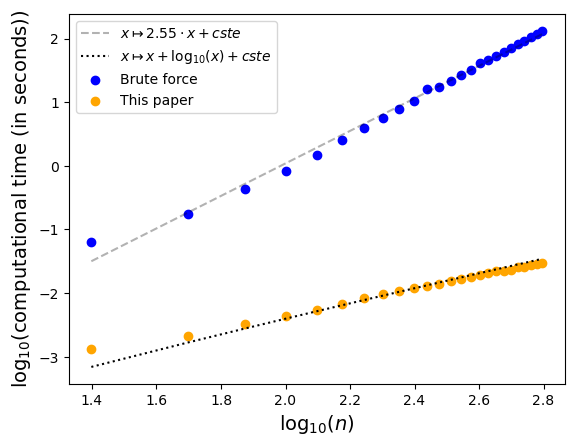

In [23]:
plt.scatter(np.log10(ls_n), np.log10(time_bruteforce), label='Brute force', color='blue')
plt.scatter(np.log10(ls_n), np.log10(time_us), label='This paper', color='orange')
y = np.log10(time_bruteforce)
x = np.concatenate((np.log10(ls_n).reshape(-1,1), np.ones((len(y), 1))), axis=1)
beta = np.linalg.inv(x.T @ x) @ x.T @ y
plt.plot(np.log10(ls_n), x @ beta, color='black', alpha=0.3, linestyle='--', label='$x\mapsto  {0}\cdot x+cste$'.format(str(np.round(beta[0],2))))
# plt.plot(np.log10(ls_n), np.log10(time_us), color='orange', linestyle='--')
# plt.plot(np.log10(ls_n), np.log10(time_bruteforce), color='blue', linestyle='--')
y = np.log10(time_us)
x = np.concatenate((np.log10(ls_n).reshape(-1,1), np.ones((len(y), 1))), axis=1)
beta = np.linalg.inv(x.T @ x) @ x.T @ y
#plt.plot(np.log10(ls_n), x @ beta, color='black', linestyle=':', label='Slope = {0}'.format(str(np.round(beta[0],2))))
vals=np.log10(ls_n*np.log10(ls_n))
plt.plot(np.log10(ls_n), vals-np.mean(vals)+np.mean(y) , color='black', linestyle=':', label='$x\mapsto x+ \log_{10}(x)+cste$')

plt.xlabel('$\log_{10}(n)$', fontsize=14)
plt.ylabel('$\log_{10}$(computational time (in seconds))', fontsize=14)
plt.legend()
plt.savefig('compute_time_white_gaussian.png', dpi=250, bbox_inches='tight')
plt.show()

# Application of CRPS-RT for group conformal prediction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import norm
from sklearn.model_selection import train_test_split
import sys
sys.path.append('../')
from UQ.UQ import UQ
import pickle
np.random.seed(0)
# Generate dataset
def generate_data(n):
    beta = np.array([1, 1])
    X = np.random.uniform(0, 1, size=(n, 2))
    noise = np.random.randn(n)
    Y = np.dot(X, beta) + noise * np.sqrt(1 + (np.dot(X, beta))**2)
    return X, Y

# Quantile Regression Forests
def train_qrf(X_train, Y_train, n_estimators=50):
    qrf = RandomForestRegressor(n_estimators=n_estimators, min_samples_leaf=10, quantile=True)
    qrf.fit(X_train, Y_train)
    return qrf

# Conformal prediction intervals
def conformal_prediction(qrf, X_cal, Y_cal, X_test, alpha=0.1):
    lower_q = alpha / 2
    upper_q = 1 - alpha / 2
    
    preds = np.array([tree.predict(X_test) for tree in qrf.estimators_]).T
    q_low = np.quantile(preds, lower_q, axis=1)
    q_high = np.quantile(preds, upper_q, axis=1)
    return q_low, q_high

# Experiment settings
n_train, n_cal, n_test = 2000, 1000, 500
X, Y = generate_data(n_train + n_cal + n_test)
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=n_cal + n_test, random_state=42)
X_cal, X_test, Y_cal, Y_test = train_test_split(X_temp, Y_temp, test_size=n_test, random_state=42)

In [2]:
x_train = X_train
x_calib = X_cal
x_test = X_test
y_train, y_calib, y_test = Y_train, Y_cal, Y_test

In [31]:
if False:
    np.save('x_train.npy', x_train)
    np.save('x_calib.npy', x_calib)
    np.save('x_test.npy', x_test)
    np.save('y_train.npy', y_train)
    np.save('y_calib.npy', y_calib)
    np.save('y_test.npy', y_test)
    import pickle
    with open('ref_tree.pickle', 'wb') as handle:
        pickle.dump(trees[0], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [2]:
x_train = np.load('x_train.npy')
x_calib = np.load('x_calib.npy')
x_test = np.load('x_test.npy')
y_train = np.load('y_train.npy')
y_calib = np.load('y_calib.npy')
y_test = np.load('y_test.npy')
with open('ref_tree.pickle', 'rb') as handle:
    trees = pickle.load(handle)
    
params = {'nTrees': 1, 'max_depth': 10, 'min_samples_split': 10, 
              'list_distri_low_quantiles': [0.005*(i+1) for i in range(60)], 'max_depth_group':2, 'use_LOO':True}

ghost = UQ(type_tree='crpsrt', nested_set='distributional', type_conformal='split-standard-vr-avg', group_coverage=True, ope_in_leaves='standard', params=params)
max_depth_group = 2
treeID2calibID2values, treeID2testID2values, treeID2calibID2group, treeID2testID2group = ghost.conf.preprocess_trees_with_groups([trees], x_calib, x_test, max_depth_group)

In [3]:
groups = list(set(treeID2testID2group[0].values()))
group2size = {group: 0 for group in groups}
for i, group in treeID2testID2group[0].items():
    group2size[group] += 1

def get_size(conf_set):
    size = 0
    for interval in conf_set:
        size += interval[1]-interval[0]
    return size
def get_cov(conf_set, ytesti):
    cov = 0
    for interval in conf_set:
        if (interval[0]<=ytesti) and (ytesti<=interval[1]):
            cov = 1
    return cov

def samplepred2groupcov(sample2predset):
    group2cov = {group : 0 for group in groups}
    group2width = {group : 0 for group in groups}
    group2cov['marginal'] = 0
    group2width['marginal'] = 0
    for i, group in treeID2testID2group[0].items():
        group2width[group] += get_size(sample2predset[i]) / group2size[group]
        group2cov[group] += get_cov(sample2predset[i], y_test[i]) / group2size[group]
        group2cov['marginal'] += get_cov(sample2predset[i], y_test[i]) / len(y_test)
        group2width['marginal'] += get_size(sample2predset[i]) / len(y_test)        
    return group2width, group2cov

In [1]:
alpha_ref = 0.1
model_configs = [
            ('CRPS-RT', 'crpsrt', 'CRPS', 'split-standard-vr-avg', 'distributional', True, alpha_ref)
        ]

for model_name, folder_name, type_tree, type_conformal, nested_set, group_coverage, alpha in model_configs:
    print(f'method: {model_name}')
    params = {'nTrees': 1, 'max_depth': 10, 'min_samples_split': 10 if 'VR' in model_name else 20, 
              'list_distri_low_quantiles': [0.005*(i+1) for i in range(60)], 'max_depth_group':2, 'use_LOO':True}

    model = UQ(type_tree=type_tree, nested_set=nested_set, type_conformal=type_conformal, group_coverage=group_coverage, ope_in_leaves='standard', params=params)

    print(f'Training {type_tree} trees')
    trees, sample2calib_trees = model.train_trees(x_train, y_train)

    group2size, group2cov, treeID2testID2group, sample2predset = model.conf.get_conformal_set_split_group_coverage(trees, x_test, y_test, x_calib, y_calib, model.params['max_depth_group'], alpha)

method: CRPS-RT


NameError: name 'UQ' is not defined

In [4]:
alpha_ref = 0.1
model_configs = [
            ('RT', 'rt', 'RT', 'split-standard-vr-avg', 'CQR', False, alpha_ref)
        ]

for model_name, folder_name, type_tree, type_conformal, nested_set, group_coverage, alpha in model_configs:
    print(f'method: {model_name}')
    params = {'nTrees': 20, 'max_depth': 10, 'min_samples_split': 10 if 'VR' in model_name else 20, 
              'nominal_quantiles': [0.2], 'use_LOO':True}

    model_RT = UQ(type_tree=type_tree, nested_set=nested_set, type_conformal=type_conformal, group_coverage=group_coverage, ope_in_leaves='standard', params=params)

    print(f'Training {type_tree} trees')
    interval_JK_RT, sample2predset_RT, widths_RT, coverages_RT = model_RT.conformal_split(x_train, y_train, x_test, y_test, x_calib, y_calib, alpha)

method: RT
Training RT trees


100%|█████████████████████████████████████████| 500/500 [09:31<00:00,  1.14s/it]


In [23]:
def get_cov(conf_set, ytesti):
    cov = 0
    for interval in conf_set:
        if (interval[0]<=ytesti) and (ytesti<=interval[1]):
            cov = 1
    return cov

In [5]:
groups = list(set(treeID2testID2group[0].values()))

def get_size(conf_set):
    size = 0
    for interval in conf_set:
        size += interval[1]-interval[0]
    return size
widths = [get_size(conf_set) for conf_set in sample2predset.values()]

group2cov_RT = {group : 0 for group in groups}
group2width_RT = {group : 0 for group in groups}
for i, group in treeID2testID2group[0].items():
    group2width_RT[group] += get_size(sample2predset_RT[0][i]) / group2size[group]
    group2cov_RT[group] += coverages_RT[0][i] / group2size[group]
    
    
group2width = {group: 0 for group in groups}
for i, group in treeID2testID2group[0].items():
    group2width[group] += get_size(sample2predset[i]) / group2size[group]   

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


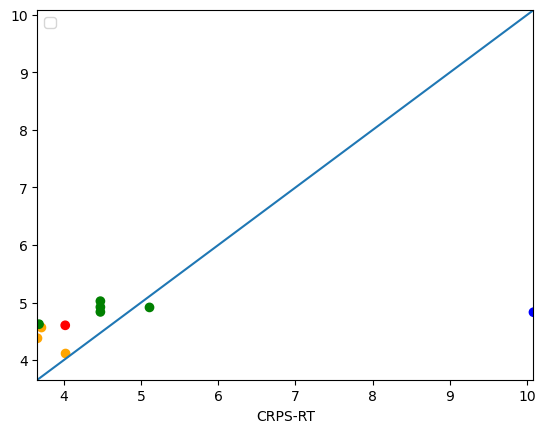

In [6]:
setcolors = ['red','blue','green','orange']
group2color = {group: setcolors[i] for i,group in enumerate(groups)}
colors = ['' for i in range(len(y_test))]
for testID, group in treeID2testID2group[0].items():
    colors[testID] = group2color[group]

low = min([np.min(widths),np.min(widths_RT[0])])
up = max([np.max(widths),np.max(widths_RT[0])])

plt.scatter(widths, widths_RT[0], c=colors)
plt.xlabel('CRPS-RT')
plt.legend()
plt.ylim(low,up)
plt.xlim(low,up)
plt.plot([low,up],[low,up])

In [28]:
import numpy as np
import matplotlib.pyplot as plt

def plot_tree_regions(tree, xlow, xup, ylow, yup, group, group2color, depth=0, maxdepth=1, crpsmode='CRPS-RT'):
    if tree is None or depth>maxdepth:
        return
    
    # Get the current split information
    threshold = tree.threshold
    feature_index = tree.feature_index
    
    yshift = 0.1
    
    if feature_index == 0:  # Split on x-axis
        if maxdepth==len(group):
            color = group2color[group+str(0)]
            plt.fill_betweenx([ylow, yup], xlow, threshold, color=color, alpha=0.3)
            color = group2color[group+str(1)]
            plt.fill_betweenx([ylow, yup], threshold, xup, color=color, alpha=0.3)
            xpos, ypos = (threshold + xup)/2,  (ylow + yup)*0.5+yshift
            plt.annotate(f'{crpsmode} Coverage: '+str(np.round(group2cov[group+'1'], 2)), xy=(xpos, ypos), ha='center')
            plt.annotate(f'{crpsmode} Mean width: '+str(np.round(group2width[group+'1'], 2)), xy=(xpos, ypos-0.05), ha='center')
            xpos, ypos = (xlow + threshold)/2,  (ylow + yup)*0.5+yshift
            plt.annotate(f'{crpsmode} Coverage: '+str(np.round(group2cov[group+'0'], 2)), xy=(xpos, ypos), ha='center')
            plt.annotate(f'{crpsmode} Mean width: '+str(np.round(group2width[group+'0'], 2)), xy=(xpos, ypos-0.05), ha='center')

            xpos, ypos = (threshold + xup)/2,  (ylow + yup)*0.5+yshift
            plt.annotate('RF Coverage: '+str(np.round(group2cov_RT[group+'1'], 2)), xy=(xpos, ypos-0.15), ha='center')
            plt.annotate('RF Mean width: '+str(np.round(group2width_RT[group+'1'], 2)), xy=(xpos, ypos-0.2), ha='center')
            xpos, ypos = (xlow + threshold)/2,  (ylow + yup)*0.5+yshift
            plt.annotate('RF Coverage: '+str(np.round(group2cov_RT[group+'0'], 2)), xy=(xpos, ypos-0.15), ha='center')
            plt.annotate('RF Mean width: '+str(np.round(group2width_RT[group+'0'], 2)), xy=(xpos, ypos-0.2), ha='center')

        plot_tree_regions(tree.left, xlow, threshold, ylow, yup, group+'0', group2color, depth + 1, maxdepth=maxdepth)
        plot_tree_regions(tree.right, threshold, xup, ylow, yup, group+'1', group2color, depth + 1, maxdepth=maxdepth)
    elif feature_index == 1:  # Split on y-axis
        if maxdepth==len(group):
            color = group2color[group+str(1)]
            plt.fill_between([xlow, xup], ylow, threshold, color=color, alpha=0.3)
            color = group2color[group+str(0)]
            plt.fill_between([xlow, xup], threshold, yup, color=color, alpha=0.3)
            xpos, ypos = (xlow + xup)/2,  (threshold + yup)*0.5+yshift
            plt.annotate(f'{crpsmode} Coverage: '+str(np.round(group2cov[group+'0'], 2)), xy=(xpos, ypos), ha='center')
            plt.annotate(f'{crpsmode} Mean width: '+str(np.round(group2width[group+'0'], 2)), xy=(xpos, ypos-0.05), ha='center')
            xpos, ypos = (xlow + xup)/2,  (ylow + threshold)*0.5+yshift
            plt.annotate(f'{crpsmode} Coverage: '+str(np.round(group2cov[group+'1'], 2)), xy=(xpos, ypos), ha='center')
            plt.annotate(f'{crpsmode} Mean width: '+str(np.round(group2width[group+'1'], 2)), xy=(xpos, ypos-0.05), ha='center')

            xpos, ypos = (xlow + xup)/2,  (threshold + yup)*0.5+yshift
            plt.annotate('RF Coverage: '+str(np.round(group2cov_RT[group+'0'], 2)), xy=(xpos, ypos-0.15), ha='center')
            plt.annotate('RF Mean width: '+str(np.round(group2width_RT[group+'0'], 2)), xy=(xpos, ypos-0.2), ha='center')
            xpos, ypos = (xlow + xup)/2,  (ylow + threshold)*0.5+yshift
            plt.annotate('RF Coverage: '+str(np.round(group2cov_RT[group+'1'], 2)), xy=(xpos, ypos-0.15), ha='center')
            plt.annotate('RF Mean width: '+str(np.round(group2width_RT[group+'1'], 2)), xy=(xpos, ypos-0.2), ha='center')

        plot_tree_regions(tree.left, xlow, xup, ylow, threshold, group+'0', group2color, depth + 1, maxdepth=maxdepth)
        plot_tree_regions(tree.right, xlow, xup, threshold, yup, group+'1', group2color, depth + 1, maxdepth=maxdepth)

def visualize_tree(trees, group2color, xlow=0, xup=1, ylow=0, yup=1, maxdepth=1, namefig=None):
    plt.figure(figsize=(8, 8))
    plot_tree_regions(trees[0], xlow, xup, ylow, yup, '', group2color, maxdepth=maxdepth)
    plt.xlim(xlow, xup)
    plt.ylim(ylow, yup)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14)
    if not(namefig is None):
        plt.savefig(namefig, dpi=250, bbox_inches='tight')
    plt.show()

In [39]:
test_tree.threshold, test_tree.left.threshold,  test_tree.right.threshold

(0.5222958892999013, 0.4725419626713333, 0.5904970843285029)

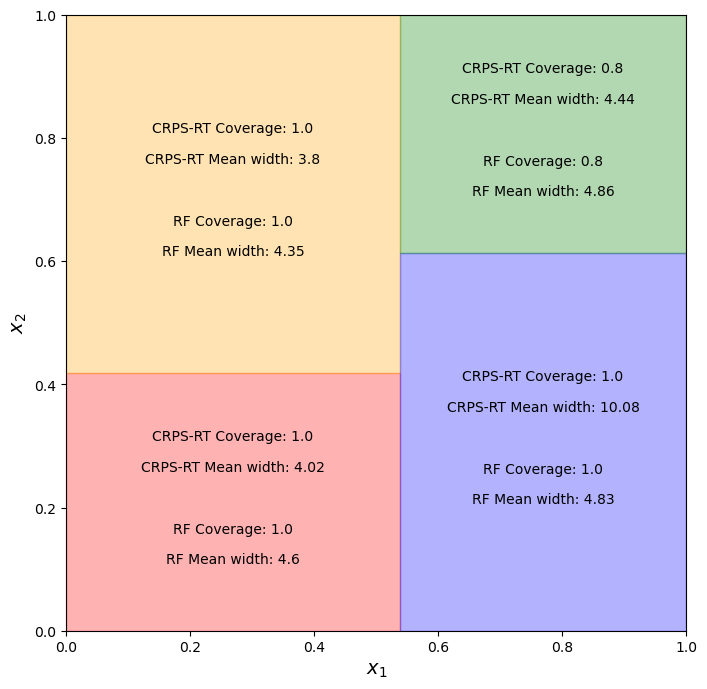

In [10]:
visualize_tree(trees, group2color, namefig='group_conformal_CRPS_RT.png')

In [11]:
np.mean(coverages_RT[0]),np.mean(widths_RT[0])

(0.9, 4.681708934638578)

In [12]:
cov = 0
wi = 0
n = 0
for group, gcov in group2cov.items():
    cov += gcov * group2size[group]
    wi += group2width[group] * group2size[group]
    n += group2size[group]
print(cov/n, wi/n)

0.9 4.769891527511033


In [5]:
### Several CRPS-RT using the same partition

alpha_ref = 0.1
model_configs = [
            ('CRPS-RT', 'crpsrt', 'CRPS', 'split-standard-vr-avg', 'distributional', True, alpha_ref)
        ]

for model_name, folder_name, type_tree, type_conformal, nested_set, group_coverage, alpha in model_configs:
    print(f'method: {model_name}')
    
    # Ref tree
    params = {'nTrees': 1, 'max_depth': 10, 'min_samples_split': 10 if 'VR' in model_name else 20, 
              'list_distri_low_quantiles': [0.005*(i+1) for i in range(60)], 'max_depth_group':2, 'use_LOO':True}
    model = UQ(type_tree=type_tree, nested_set=nested_set, type_conformal=type_conformal, group_coverage=group_coverage, ope_in_leaves='standard', params=params)
    trees, sample2calib_trees = model.train_trees(x_train, y_train)

    
    
    params = {'nTrees': 20, 'max_depth': 10, 'min_samples_split': 10 if 'VR' in model_name else 20, 
              'list_distri_low_quantiles': [0.005*(i+1) for i in range(60)], 'max_depth_group':2, 'use_LOO':True}

    model_multi = UQ(type_tree=type_tree, nested_set=nested_set, type_conformal=type_conformal, group_coverage=group_coverage, ope_in_leaves='standard', params=params)

    print(f'Training {type_tree} trees')
    trees_multi, sample2calib_trees = model_multi.train_trees(x_train, y_train, ref_tree=trees[0], max_depth_ref_tree=2)

    group2size, group2cov, treeID2testID2group, sample2predset = model_multi.conf.get_conformal_set_split_group_coverage(trees_multi, x_test, y_test, x_calib, y_calib, model.params['max_depth_group'], alpha)

method: CRPS-RT


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.89s/it]


Training CRPS trees


100%|███████████████████████████████████████████| 20/20 [00:10<00:00,  1.82it/s]


10 idx 28 9
01 idx 26 11
00 idx 25 8
11 idx 19 8


100%|█████████████████████████████████████████| 500/500 [25:42<00:00,  3.09s/it]


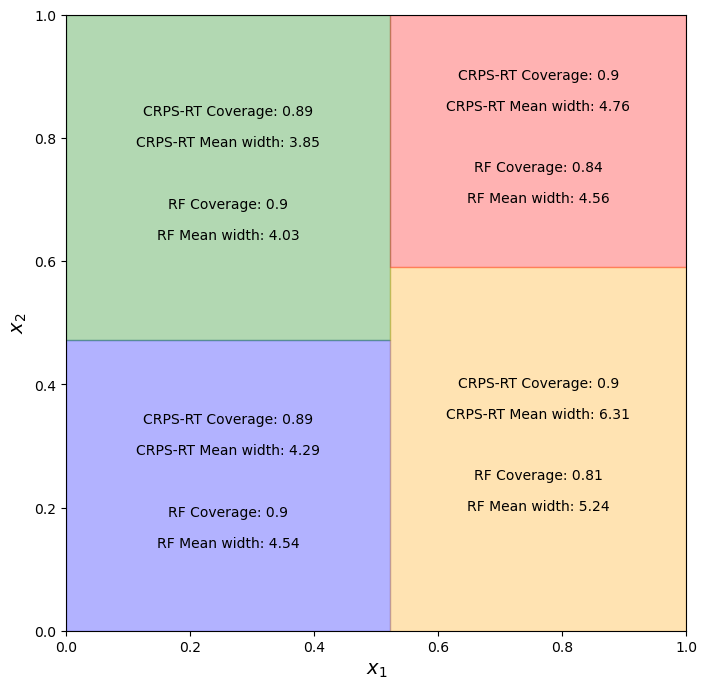

In [15]:
groups = list(set(treeID2testID2group[0].values()))
setcolors = ['red','blue','green','orange']
group2color = {group: setcolors[i] for i,group in enumerate(groups)}
colors = ['' for i in range(len(y_test))]
def get_size(conf_set):
    size = 0
    for interval in conf_set:
        size += interval[1]-interval[0]
    return size
widths = [get_size(conf_set) for conf_set in sample2predset.values()]

group2cov_RT = {group : 0 for group in groups}
group2width_RT = {group : 0 for group in groups}
for i, group in treeID2testID2group[0].items():
    group2width_RT[group] += get_size(sample2predset_RT[0][i]) / group2size[group]
    group2cov_RT[group] += coverages_RT[0][i] / group2size[group]
    
    
group2width = {group: 0 for group in groups}
for i, group in treeID2testID2group[0].items():
    group2width[group] += get_size(sample2predset[i]) / group2size[group]   
    
    
visualize_tree(trees, group2color, namefig='group_conformal_CRPS_RF.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


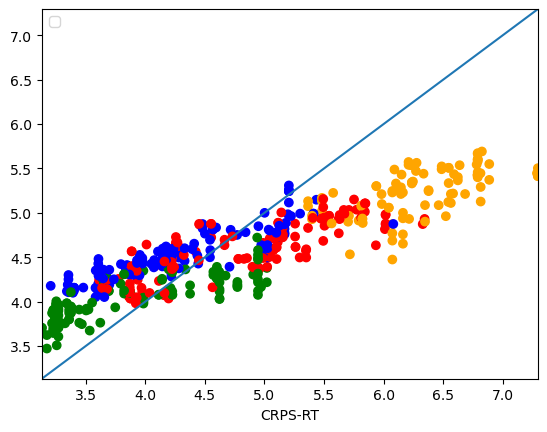

In [9]:

for testID, group in treeID2testID2group[0].items():
    colors[testID] = group2color[group]

low = min([np.min(widths),np.min(widths_RT[0])])
up = max([np.max(widths),np.max(widths_RT[0])])

plt.scatter(widths, widths_RT[0], c=colors)
plt.xlabel('CRPS-RT')
plt.legend()
plt.ylim(low,up)
plt.xlim(low,up)
plt.plot([low,up],[low,up])

In [10]:
np.mean(coverages_RT[0]),np.mean(widths_RT[0])

(0.866, 4.54932826464921)

In [11]:
cov = 0
wi = 0
n = 0
for group, gcov in group2cov.items():
    cov += gcov * group2size[group]
    wi += group2width[group] * group2size[group]
    n += group2size[group]
print(cov/n, wi/n)

0.884 4.702761500279494


In [14]:
group2cov['10'] = 0.902

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def plot_tree_regions(tree, xlow, xup, ylow, yup, group, group2color, depth=0, maxdepth=1, crpsmode='CRPS-RT'):
    if tree is None or depth>maxdepth:
        return
    
    # Get the current split information
    threshold = tree.threshold
    feature_index = tree.feature_index
    
    yshift = 0.1
    
    if feature_index == 0:  # Split on x-axis
        if maxdepth==len(group):
            color = group2color[group+str(0)]
            plt.fill_betweenx([ylow, yup], xlow, threshold, color=color, alpha=0.3)
            color = group2color[group+str(1)]
            plt.fill_betweenx([ylow, yup], threshold, xup, color=color, alpha=0.3)

        plot_tree_regions(tree.left, xlow, threshold, ylow, yup, group+'0', group2color, depth + 1, maxdepth=maxdepth)
        plot_tree_regions(tree.right, threshold, xup, ylow, yup, group+'1', group2color, depth + 1, maxdepth=maxdepth)
    elif feature_index == 1:  # Split on y-axis
        if maxdepth==len(group):
            color = group2color[group+str(1)]
            plt.fill_between([xlow, xup], ylow, threshold, color=color, alpha=0.3)
            color = group2color[group+str(0)]
            plt.fill_between([xlow, xup], threshold, yup, color=color, alpha=0.3)

        plot_tree_regions(tree.left, xlow, xup, ylow, threshold, group+'0', group2color, depth + 1, maxdepth=maxdepth)
        plot_tree_regions(tree.right, xlow, xup, threshold, yup, group+'1', group2color, depth + 1, maxdepth=maxdepth)

def visualize_tree(trees, group2color, xlow=0, xup=1, ylow=0, yup=1, maxdepth=1, namefig=None):
    plt.figure()
    plot_tree_regions(trees[0], xlow, xup, ylow, yup, '', group2color, maxdepth=maxdepth)
    plt.xlim(xlow, xup)
    plt.ylim(ylow, yup)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14)
    if not(namefig is None):
        plt.savefig(namefig, dpi=250, bbox_inches='tight')
    plt.show()

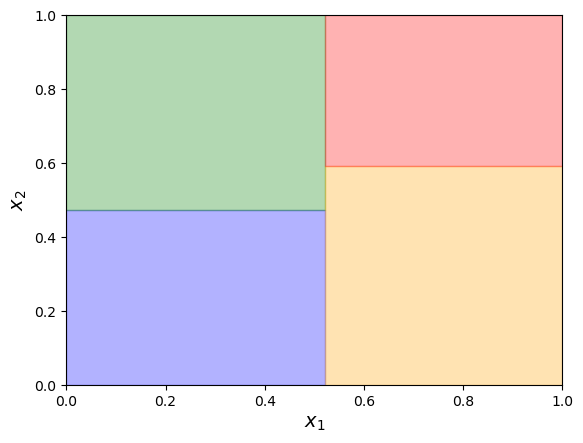

In [20]:
visualize_tree(trees, group2color, namefig='group_conformal_partition.png')

In [6]:
##################
# Group conformal for QRF-CQR with first two depths fixed
##################
alpha_ref = 0.1
model_configs = [
            ('RT', 'rt', 'RT', 'split-standard-vr', 'CQR', True, alpha_ref)
        ]

for model_name, folder_name, type_tree, type_conformal, nested_set, group_coverage, alpha in model_configs:
    print(f'method: {model_name}')
    params = {'nTrees': 20, 'max_depth': 10, 'min_samples_split': 10 if 'VR' in model_name else 20, 
              'nominal_quantiles': [0.2], 'use_LOO':True, 'max_depth_group':2}

    model_RT = UQ(type_tree=type_tree, nested_set=nested_set, type_conformal=type_conformal, group_coverage=group_coverage, ope_in_leaves='standard', params=params)

    print(f'Training {type_tree} trees')
    trees_RT, _ = model_RT.train_trees(x_train, y_train, ref_tree=trees, max_depth_ref_tree=2)
    interval_JK, sample2predset = model_RT.conf.get_conformal_set_split_group_coverage(trees_RT, x_test, y_test, x_calib, y_calib, model_RT.params['max_depth_group'], alpha)

method: RT
Training RT trees


100%|█████████████████████████████████████████| 500/500 [09:26<00:00,  1.13s/it]


In [8]:
samplepred2groupcov(sample2predset[0])

({'00': 3.4659723467308847,
  '10': 4.942553582208672,
  '11': 6.303954847944568,
  '01': 4.313463878603712,
  'marginal': 4.661270538757801},
 {'00': 0.8320610687022912,
  '10': 0.8767123287671258,
  '11': 0.9072164948453597,
  '01': 0.8650793650793629,
  'marginal': 0.8680000000000007})

In [5]:
samplepred2groupcov(sample2predset[0])

({'00': 3.443266607927776,
  '10': 5.013427219358185,
  '11': 6.354874692440902,
  '01': 4.182934249947884,
  'marginal': 4.653001720650068},
 {'00': 0.8396946564885508,
  '10': 0.883561643835619,
  '11': 0.8969072164948443,
  '01': 0.8333333333333313,
  'marginal': 0.8620000000000007})

In [9]:
group2size

{'00': 131, '10': 146, '11': 97, '01': 126}

In [22]:
##################
# Marginal conformal for CRPS-RT distri
##################
alpha_ref = 0.1
model_configs = [
            ('CRPS-RT', 'crpsrt', 'CRPS', 'split-standard-vr-avg', 'distributional', False, alpha_ref)
        ]

for model_name, folder_name, type_tree, type_conformal, nested_set, group_coverage, alpha in model_configs:
    print(f'method: {model_name}')
    
    # Ref tree
    params = {'nTrees': 1, 'max_depth': 10, 'min_samples_split': 10 if 'VR' in model_name else 20, 
              'list_distri_low_quantiles': [0.005*(i+1) for i in range(60)], 'max_depth_group':2, 'use_LOO':True}
    model = UQ(type_tree=type_tree, nested_set=nested_set, type_conformal=type_conformal, group_coverage=group_coverage, ope_in_leaves='standard', params=params)
    trees, sample2calib_trees = model.train_trees(x_train, y_train)

    
    
    params = {'nTrees': 20, 'max_depth': 10, 'min_samples_split': 10 if 'VR' in model_name else 20, 
              'list_distri_low_quantiles': [0.005*(i+1) for i in range(60)], 'max_depth_group':2, 'use_LOO':True}

    model_multi = UQ(type_tree=type_tree, nested_set=nested_set, type_conformal=type_conformal, group_coverage=group_coverage, ope_in_leaves='standard', params=params)

    print(f'Training {type_tree} trees')
    trees_multi, sample2calib_trees = model_multi.train_trees(x_train, y_train)

    _, sample2predset = model_multi.conf.get_conformal_set_split(trees_multi, x_test, y_test, x_calib, y_calib, alpha)

method: CRPS-RT


100%|█████████████████████████████████████████| 1/1 [00:01<00:00,  1.77s/it]


Training CRPS trees


100%|███████████████████████████████████████| 20/20 [00:17<00:00,  1.13it/s]


In [26]:
group2cov_RT = {group : 0 for group in groups}
group2width_RT = {group : 0 for group in groups}
for i, group in treeID2testID2group[0].items():
    group2width_RT[group] += get_size(sample2predset[i]) / group2size[group]
    group2cov_RT[group] += get_cov(sample2predset[i], y_test[i]) / group2size[group]
    
    
group2width = {group: 0 for group in groups}
for i, group in treeID2testID2group[0].items():
    group2width[group] += get_size(sample2predset[i]) / group2size[group]   

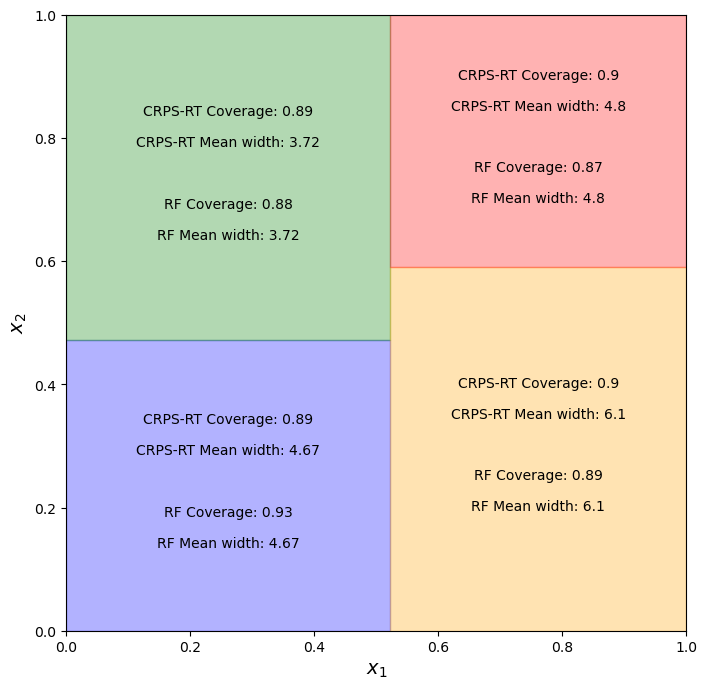

In [29]:
visualize_tree(trees, group2color, namefig='group_conformal_CRPS_RF.png')

In [30]:
cov = 0
wi = 0
n = 0
for group, gcov in group2cov_RT.items():
    cov += gcov * group2size[group]
    wi += group2width_RT[group] * group2size[group]
    n += group2size[group]
print(cov/n, wi/n)

0.8900000000000002 4.737409573595029
